Note: Unduh dataset Indonesia Reading Interest https://www.kaggle.com/datasets/imaditia/indonesia-reading-interest-2020-2023?resource=download dan unggah melalui menu unggah file di samping. Anda juga bisa mengunggahnya pada Google Drive untuk di-mount

In [ ]:
# 1. Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Ensure plots display inline in Colab
%matplotlib inline

In [ ]:
# 2. Read the dataset
df = pd.read_csv("/content/TGM 2020-2023_eng.csv", sep=";")

# Print detected column names
print("=== Detected Columns ===")
print(df.columns.tolist(), "\n")

=== Detected Columns ===
['Provinsi', 'Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)', 'Category'] 



In [ ]:
# 3. Display the first few rows to verify the structure
print("=== First 5 Rows ===")
print(df.head(), "\n")

=== First 5 Rows ===
  Provinsi  Year Reading Frequency per week Number of Readings per Quarter  \
0     Aceh  2020                          4                              2   
1     Aceh  2021                        5,5                            4,5   
2     Aceh  2022                          5                            5,5   
3     Aceh  2023                          5                            5,5   
4     Bali  2020                          4                            2,5   

  Daily Reading Duration (in minutes) Internet Access Frequency per Week  \
0                                  95                                NaN   
1                                 103                                  5   
2                                94,3                                5,5   
3                                  95                                5,5   
4                                  91                                NaN   

  Daily Internet Duration (in minutes)  \
0          

In [ ]:
# 4. Basic exploration: info, describe, missing values
print("=== DataFrame Info ===")
print(df.info(), "\n")
print("=== Descriptive Statistics ===")
print(df.describe(include='all'), "\n")
print("=== Missing Values Per Column ===")
print(df.isnull().sum(), "\n")

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Provinsi                                      140 non-null    object
 1   Year                                          140 non-null    int64 
 2   Reading Frequency per week                    140 non-null    object
 3   Number of Readings per Quarter                140 non-null    object
 4   Daily Reading Duration (in minutes)           140 non-null    object
 5   Internet Access Frequency per Week            105 non-null    object
 6   Daily Internet Duration (in minutes)          105 non-null    object
 7   Tingkat Kegemaran Membaca (Reading Interest)  140 non-null    object
 8   Category                                      140 non-null    object
dtypes: int64(1), object(8)
memory usage: 10.0+ KB
None 

=

In [ ]:
# 5. Remove duplicate rows (if any)
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("After removing duplicates, shape:", df.shape, "\n")
else:
    print("No duplicate rows found.\n")

Number of duplicate rows: 0
No duplicate rows found.



In [ ]:
# 6. Handle missing values and convert columns that contain commas to proper numeric
# Define the reading interest column
reading_col = "Tingkat Kegemaran Membaca (Reading Interest)"

# List of columns with numeric values stored as strings (with commas)
numeric_cols_with_commas = [
    "Reading Frequency per week",
    "Number of Readings per Quarter",
    "Daily Reading Duration (in minutes)",
    "Internet Access Frequency per Week",
    "Daily Internet Duration (in minutes)",
    reading_col
]

for col in numeric_cols_with_commas:
    if col in df.columns:
        # Replace commas with dots
        df[col] = df[col].astype(str).str.replace(',', '.')
        # Convert to numeric
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Fill missing with median
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Missing values in '{col}' filled with median: {median_val}")

# Convert "Year" to numeric if it exists
if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    year_median = df['Year'].median()
    df['Year'] = df['Year'].fillna(year_median)
    print(f"Missing values in 'Year' filled with median: {year_median}")

# Fill missing values in categorical columns with mode
categorical_cols = ["Provinsi", "Category"]
for cat_col in categorical_cols:
    if cat_col in df.columns:
        mode_val = df[cat_col].mode()[0]
        df[cat_col] = df[cat_col].fillna(mode_val)
        print(f"Missing values in '{cat_col}' filled with mode: {mode_val}")
print()

Missing values in 'Reading Frequency per week' filled with median: 4.75
Missing values in 'Number of Readings per Quarter' filled with median: 4.5
Missing values in 'Daily Reading Duration (in minutes)' filled with median: 97.2
Missing values in 'Internet Access Frequency per Week' filled with median: 5.5
Missing values in 'Daily Internet Duration (in minutes)' filled with median: 113.7
Missing values in 'Tingkat Kegemaran Membaca (Reading Interest)' filled with median: 62.195
Missing values in 'Year' filled with median: 2021.5
Missing values in 'Provinsi' filled with mode: Aceh
Missing values in 'Category' filled with mode: Moderate



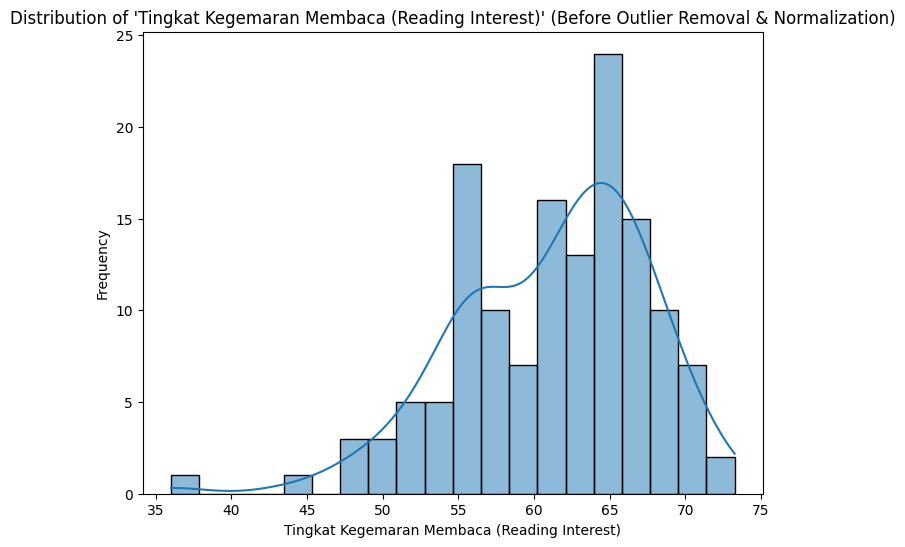

In [ ]:
# 7. Visualize the reading interest BEFORE normalization
plt.figure(figsize=(8, 6))
sns.histplot(df[reading_col], bins=20, kde=True)
plt.title(f"Distribution of '{reading_col}' (Before Outlier Removal & Normalization)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

Numeric columns: ['Year', 'Reading Frequency per week', 'Number of Readings per Quarter', 'Daily Reading Duration (in minutes)', 'Internet Access Frequency per Week', 'Daily Internet Duration (in minutes)', 'Tingkat Kegemaran Membaca (Reading Interest)'] 

Column 'Year': 0 outliers detected.
Column 'Reading Frequency per week': 0 outliers detected.
Column 'Number of Readings per Quarter': 0 outliers detected.
Column 'Daily Reading Duration (in minutes)': 0 outliers detected.
Column 'Internet Access Frequency per Week': 9 outliers detected.
Column 'Daily Internet Duration (in minutes)': 1 outliers detected.
Column 'Tingkat Kegemaran Membaca (Reading Interest)': 1 outliers detected.

Shape after outlier removal: (129, 9)


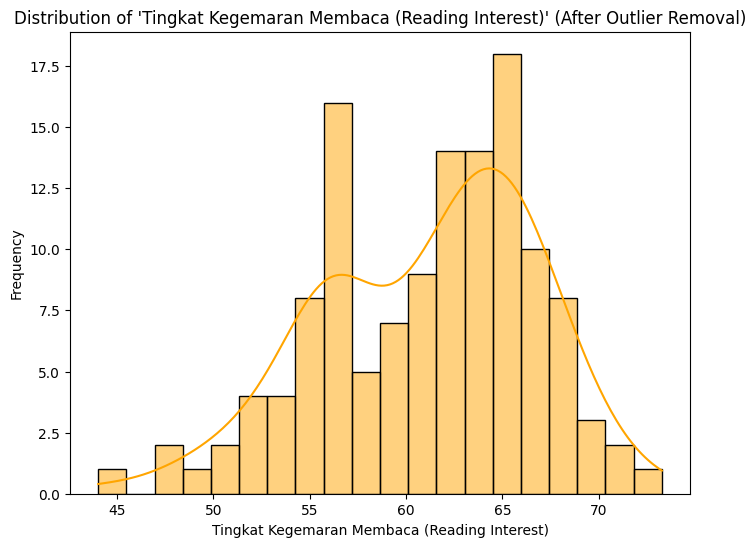

In [ ]:
# 8. Detect and remove outliers using the IQR method
def remove_outliers_iqr(data, cols):
    data_clean = data.copy()
    for c in cols:
        Q1 = data_clean[c].quantile(0.15)
        Q3 = data_clean[c].quantile(0.85)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_indices = data_clean[(data_clean[c] < lower_bound) | (data_clean[c] > upper_bound)].index
        print(f"Column '{c}': {len(outlier_indices)} outliers detected.")
        data_clean = data_clean.drop(index=outlier_indices)
    return data_clean

# Identify numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols, "\n")

# Remove outliers from numeric columns
df_no_outliers = remove_outliers_iqr(df, numeric_cols)
print("\nShape after outlier removal:", df_no_outliers.shape)

# Visualize the reading interest AFTER outlier removal
plt.figure(figsize=(8, 6))
sns.histplot(df_no_outliers[reading_col], bins=20, kde=True, color='orange')
plt.title(f"Distribution of '{reading_col}' (After Outlier Removal)")
plt.xlabel(reading_col)
plt.ylabel("Frequency")
plt.show()

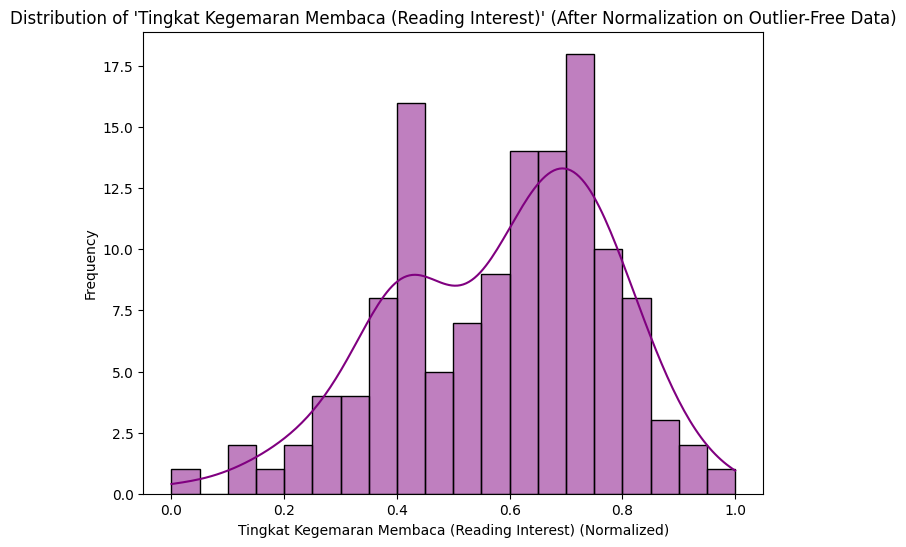


Sample of normalized data (after outlier removal):
  Provinsi      Year  Reading Frequency per week  \
0     Aceh  0.000000                         0.4   
1     Aceh  0.333333                         1.0   
2     Aceh  0.666667                         0.8   
3     Aceh  1.000000                         0.8   
4     Bali  0.000000                         0.4   

   Number of Readings per Quarter  Daily Reading Duration (in minutes)  \
0                        0.111111                             0.507246   
1                        0.666667                             0.623188   
2                        0.888889                             0.497101   
3                        0.888889                             0.507246   
4                        0.222222                             0.449275   

   Internet Access Frequency per Week  Daily Internet Duration (in minutes)  \
0                            0.666667                              0.523726   
1                            0.3

In [ ]:
# 9. Normalize the data AFTER outlier removal using MinMaxScaler
df_no_outliers_normalized = df_no_outliers.copy()
scaler = MinMaxScaler()
# Re-identify numeric columns in the outlier-removed dataset
numeric_cols_no_outliers = df_no_outliers_normalized.select_dtypes(include=[np.number]).columns.tolist()
df_no_outliers_normalized[numeric_cols_no_outliers] = scaler.fit_transform(df_no_outliers_normalized[numeric_cols_no_outliers])

# Visualize the reading interest AFTER normalization
plt.figure(figsize=(8, 6))
sns.histplot(df_no_outliers_normalized[reading_col], bins=20, kde=True, color='purple')
plt.title(f"Distribution of '{reading_col}' (After Normalization on Outlier-Free Data)")
plt.xlabel(f"{reading_col} (Normalized)")
plt.ylabel("Frequency")
plt.show()

print("\nSample of normalized data (after outlier removal):")
print(df_no_outliers_normalized.head())

In [ ]:
# 10. Save the preprocessed datasets
df_no_outliers_normalized.to_csv("TGM_2020-2023_normalized.csv", index=False)
df_no_outliers.to_csv("TGM_2020-2023_cleaned.csv", index=False)
print("\nNormalized dataset (outlier-free) saved as 'TGM_2020-2023_normalized.csv'.")
print("Cleaned (no outliers) dataset saved as 'TGM_2020-2023_cleaned.csv'.")


Normalized dataset (outlier-free) saved as 'TGM_2020-2023_normalized.csv'.
Cleaned (no outliers) dataset saved as 'TGM_2020-2023_cleaned.csv'.
